In [1]:
# Copyright (c) 2023 Massachusetts Institute of Technology
# SPDX-License-Identifier: MIT

# Learned Additive Perturbation

Train a perturbation model across the entire dataset by solving the following optimization problem:

$$
\hat{δ} = \max\limits_{\|\delta\|_p<\epsilon} \mathbb{E}_{(x,y) \sim D}[\mathcal{L}(f_\theta(x+\delta), y)]
$$

The code using `rAI-toolbox` boils down to simply running the following training loop:

```python
model = # load trained model and freeze weights
perturbation = # initialize perturbation model
opt = Optim(perturbation.parameters(), ...) # define optimizer
for step in range(self.num_steps):
    for data, target in iterator:
        output = model(perturbation(data))
        loss = -cross_entropy(output, target)

        # Update perturbation parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
```

## Implementation

The code is organized as follows:

```
universal_perturbation
├── configs.py      :  hydra-zen configurations
├── perturbation.py :  The Universal Perturbation Pytorch Module
├── solver.py       :  The LightningModule
└── train.py        :  Main function to train
```

### Perturbation

The perturbation implements `nn.Module` for to learn a perturbation with shape `(C, H, W)` that is broadcast-added across the batch of data.

### Results

Here we look at analyzing results of different perturbations trained on CIFAR-10 using a standard and robust trained ResNet-50 models.  The command to reproduce the results is:

```bash
>> PYTHONPATH=$PWD:$PYTHONPATH python train.py epsilon=1,2,5,10 ckpt=mitll_cifar_nat,mitll_cifar_l2_1_0 --multirun
```

## Analysis

In [2]:
%matplotlib inline
from pathlib import Path

import configs
import matplotlib.pyplot as plt
import numpy as np
import torch
from hydra_zen import instantiate

### Load Perturbation and Metrics

In [3]:
working_dir = Path("multirun/2022-03-09/23-02-18/mitll_cifar_nat_epsilon_1/")

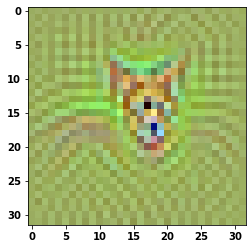

In [4]:
ckpt = list(working_dir.glob("**/*.ckpt"))[0]
pert_state = {
    k[len("perturbation.") :]: v
    for k, v in torch.load(ckpt)["state_dict"].items()
    if "perturbation." in k
}
pert = instantiate(configs.Perturbation)
pert.load_state_dict(pert_state)

x = pert_state["delta"].detach().cpu()
xmin = x.flatten(1).min(1).values.view(-1, 1, 1)
xmax = x.flatten(1).max(1).values.view(-1, 1, 1)
x = (x - xmin) / (xmax - xmin)
plt.imshow(x.permute(1, 2, 0))

Text(0.5, 1.0, 'Accuracy Model Against the UAP')

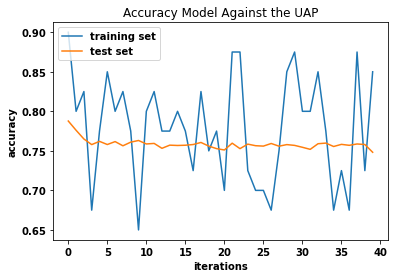

In [10]:
metrics = torch.load(working_dir / "fit_metrics.pt")
plt.plot(metrics["epoch"], metrics["Train/Accuracy"], label="training set")
plt.plot(metrics["epoch"], metrics["Val/Accuracy"], label="test set")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("Accuracy Model Against the UAP")

### Visualize Perturbation and Classification Results

Files already downloaded and verified


Text(0.5, 1.0, 'cat (frog)')

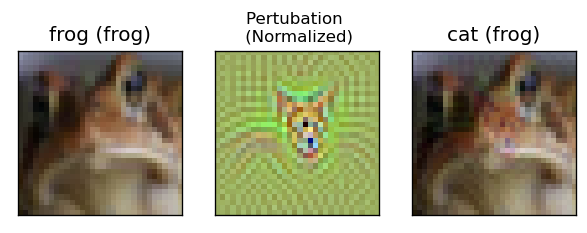

In [6]:
ds = instantiate(configs.TestCIFAR10, train=False)
model = instantiate(
    configs.CIFARModel, ckpt=str(Path.home() / ".torch/models/mitll_cifar_nat.pt")
)
model.eval()

pert = instantiate(configs.Perturbation)
pert.load_state_dict(pert_state)


data, target = ds[221]
with torch.no_grad():
    pred = model(data[None]).argmax(-1)
    xpert = pert(data[None])
    pred_p = model(xpert).argmax(-1)

    x = pert_state["delta"].detach().cpu()
    xmin = x.flatten(1).min(1).values.view(-1, 1, 1)
    xmax = x.flatten(1).max(1).values.view(-1, 1, 1)
    x = (x - xmin) / (xmax - xmin)

fig, ax = plt.subplots(ncols=3, subplot_kw=dict(xticks=[], yticks=[]), dpi=120)
ax[0].imshow(data.permute(1, 2, 0))
ax[0].set_title(f"{ds.classes[pred[0].item()]} ({ds.classes[target]})")
ax[1].imshow(x.permute(1, 2, 0))
ax[1].set_title("Pertubation \n (Normalized)", fontsize=10)
ax[2].imshow(xpert[0].permute(1, 2, 0).clamp_(0, 1))
ax[2].set_title(f"{ds.classes[pred_p[0].item()]} ({ds.classes[target]})")

## Results for Standard and Robust Models

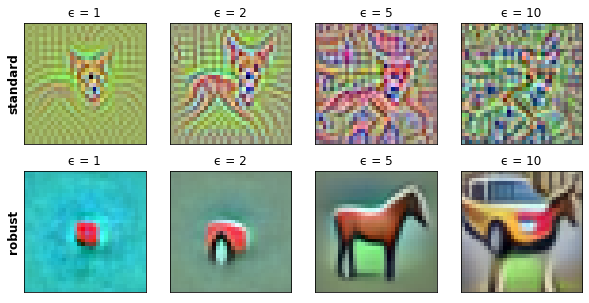

In [7]:
multirun_dir = Path("multirun/2022-03-09/23-02-18/")
ckpts = ["mitll_cifar_nat", "mitll_cifar_l2_1_0"]
epss = [1, 2, 5, 10]

xall = []
for ckpt in ckpts:
    xc = []
    for eps in epss:
        wdir = multirun_dir / f"{ckpt}_epsilon_{eps}"
        cs = list(wdir.glob("**/*.ckpt"))[0]
        pert_state = {
            k[len("perturbation.") :]: v
            for k, v in torch.load(cs)["state_dict"].items()
            if "perturbation." in k
        }
        x = pert_state["delta"].detach().cpu()
        xmin = x.flatten(1).min(1).values.view(-1, 1, 1)
        xmax = x.flatten(1).max(1).values.view(-1, 1, 1)
        x = (x - xmin) / (xmax - xmin)
        xc.append(x)
    xall.append(torch.stack(xc, dim=0))

from rai_experiments.utils.visualizations import show_image_row

es = [f"ϵ = {e}" for e in epss]
show_image_row(xall, tlist=[es, es], ylist=["standard", "robust"]);

### Correlation of Perturbaton to PCA Components

PCA components for CIFAR-10 can be found [here](https://mitlincolnlaboratory-my.sharepoint.us/:f:/g/personal/jgoodwin_ll_mit_edu/EltyrNlmdnNBrdNW6dJGDusB-WnVcutgMBAblLPgoivBEg).

Text(0, 0.5, 'Perturbation Correlation \n with Compoenent')

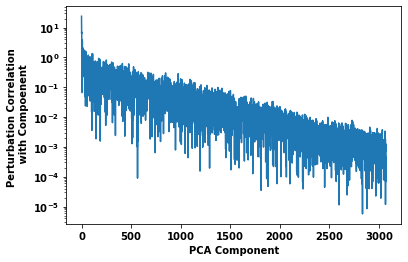

In [8]:
pca = np.load(
    Path.home() / ".torch/data/cifar10-pca/cifar_pca_3072.npy", allow_pickle=True
).item()
A = pca["components"]
m = pca["mean"]
s = pca["explained_variance"]
xx = pert_state["delta"][None].flatten(1).detach().cpu() - m[None]
plt.semilogy(abs((xx @ A.T)[0]))
plt.xlabel("PCA Component")
plt.ylabel("Perturbation Correlation \n with Compoenent")

Text(0, 0.5, 'Perturbation Correlation \n with PCA Component')

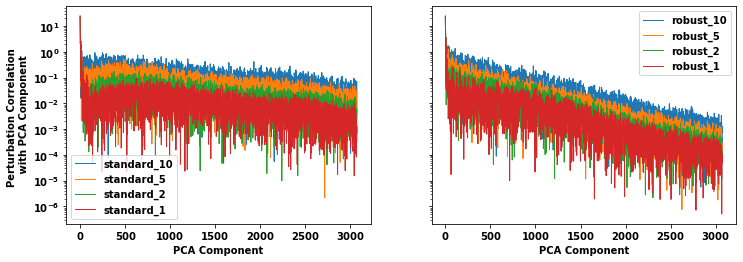

In [9]:
multirun_dir = Path("multirun/2022-03-09/23-02-18")
model_ckpts = ["mitll_cifar_nat", "mitll_cifar_l2_1_0"]
epss = [10, 5, 2, 1]

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
xall = []
for i, model_ckpt in enumerate(model_ckpts):
    c = "standard" if "nat" in model_ckpt else "robust"
    xc = []
    for eps in epss:
        ckpt = list(multirun_dir.glob(f"{model_ckpt}_epsilon_{eps}/**/last.ckpt"))[0]
        pert_state = torch.load(ckpt)["state_dict"]
        xx = pert_state["perturbation.delta"][None].flatten(1).detach().cpu() - m[None]
        ax[i].semilogy(abs((xx @ A.T)[0]), lw=1, label=f"{c}_{eps}")
    ax[i].set_xlabel("PCA Component")
    ax[i].legend()
ax[0].set_ylabel("Perturbation Correlation \n with PCA Component")

You can see that perturbations on the "standard" model align more with higher PCA components than the perturbations on the "robust" model.  An indication that the perturbations are more constrained to "high information" dimensions for the robust model.